In [1]:
import vaft

Load and test sample thomson scattering files

[INFO] Loading Thomson scattering data from: /srv/vest.diagnostic/45414_NeTe.mat (version: v11)
[INFO] Loading Thomson scattering data from: /srv/vest.diagnostic/NeTe_Shot40323_v9_rev.mat (version: v9_rev)
[INFO] Thomson data successfully loaded into ODS structures.


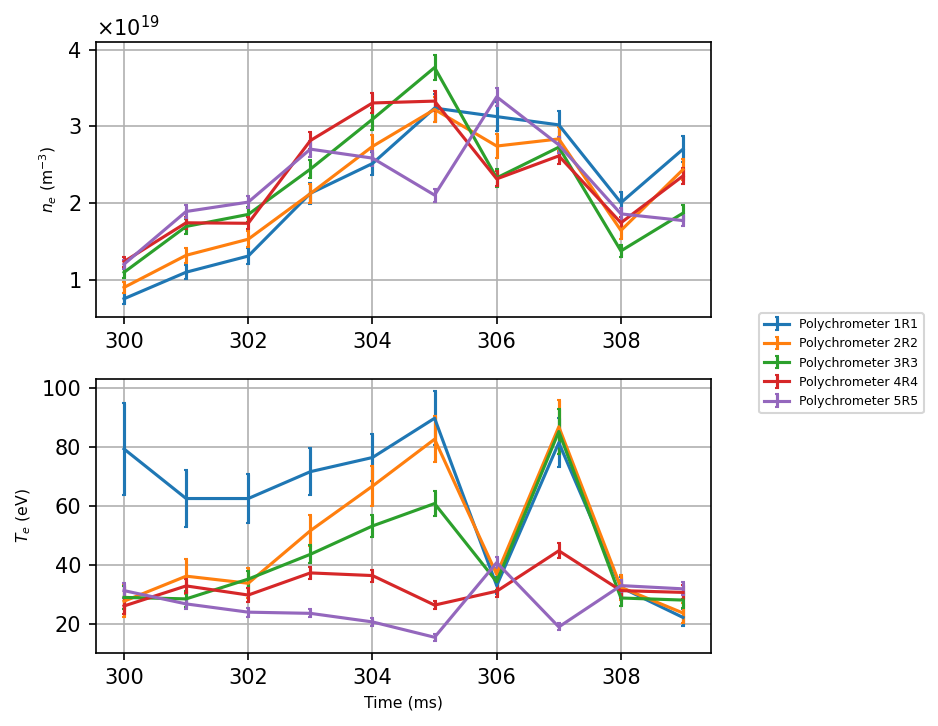

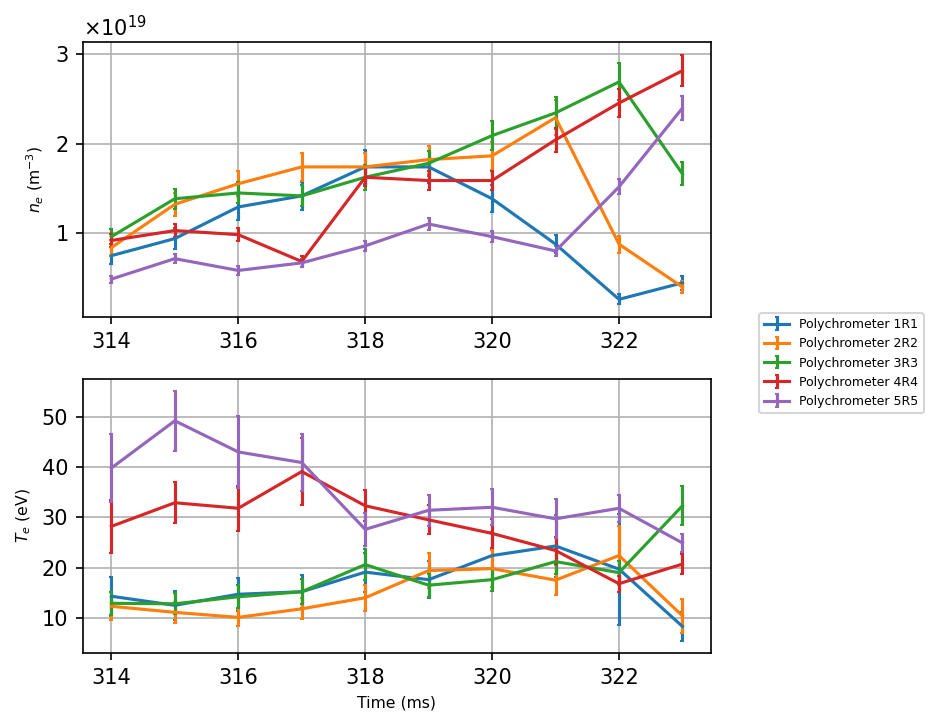

In [7]:
import vaft
from pathlib import Path
from omas import *  
import matplotlib.pyplot as plt

new_thomson = '46051_NeTe.mat'
old_thomson = 'NeTe_Shot39915_v9_rev.mat'

data_dir = Path(vaft.__file__).resolve().parent / "data"
file_new = data_dir / new_thomson
file_old = data_dir / old_thomson

ods_new_thomson = ODS()
ods_old_thomson = ODS()

file_new = '/srv/vest.diagnostic/45414_NeTe.mat'
file_old = '/srv/vest.diagnostic/NeTe_Shot40323_v9_rev.mat'
vaft.machine_mapping.thomson_scattering(ods_new_thomson, 46051, file_new)
vaft.machine_mapping.thomson_scattering(ods_old_thomson, 39915, file_old)

print("[INFO] Thomson data successfully loaded into ODS structures.")

vaft.plot.plot_thomson_time_series(ods_new_thomson)
vaft.plot.plot_thomson_time_series(ods_old_thomson)

In [2]:
df= vaft.database.exist_ts_file()

Available Thomson Scattering Shots:

|   Index |   Shot Number | Last Processed             | Status       |
|---------|---------------|----------------------------|--------------|
|       1 |         22027 | 2023-02-02T23:24:20        | invalid      |
|       2 |         39513 | 2024-08-06T11:18:45.556514 | thomson_only |
|       3 |         39515 | 2024-08-06T11:19:39.748631 | thomson_only |
|       4 |         39906 | 2024-08-06T11:20:05.668157 | core_profile |
|       5 |         39915 | 2024-05-14T16:42:35.439538 | invalid      |
|       6 |         39916 | 2024-07-08T20:11:09.953256 | core_profile |
|       7 |         39917 | 2023-07-05T20:47:14        | core_profile |
|       8 |         40282 | 2024-08-06T11:20:28.826835 | core_profile |
|       9 |         40323 | 2023-07-28T16:03:45        | invalid      |
|      10 |         40324 | 2023-07-28T16:05:23        | thomson_only |
|      11 |         40325 | 2023-07-28T16:06:39        | core_profile |
|      12 |         40326 |

In [3]:
# 
core_profile_shot=df[df['Status']=='core_profile']
print(core_profile_shot['Shot Number'].values)

[39906 39916 39917 40282 40325 40326 40327 40330 41262 41672 42759 42947
 42962 43876 43877 43880 44162 44165 44404 44405 44411 44412 44413 44418
 44419 44421 44427 44428 44430 44438 45531 45534 45537 45538]


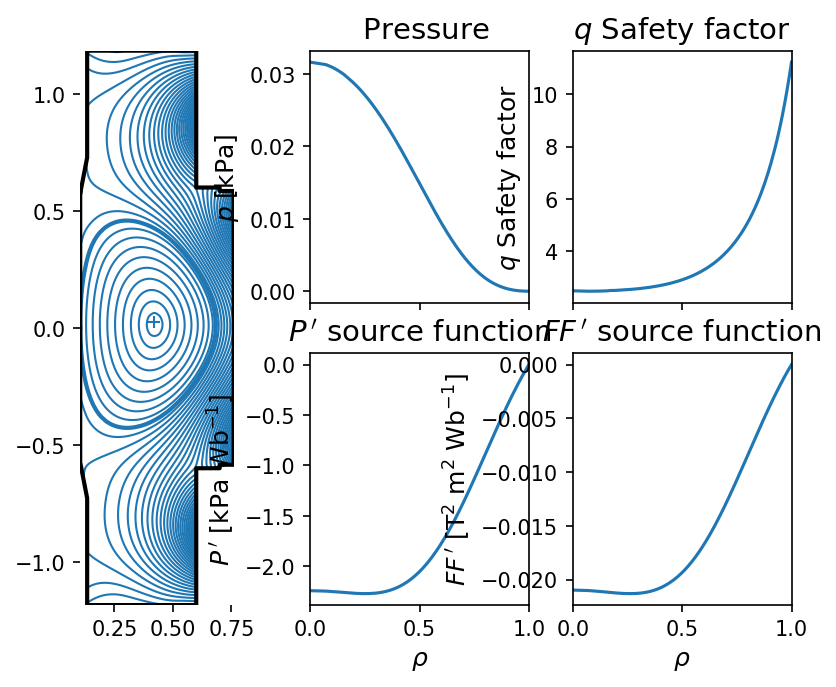

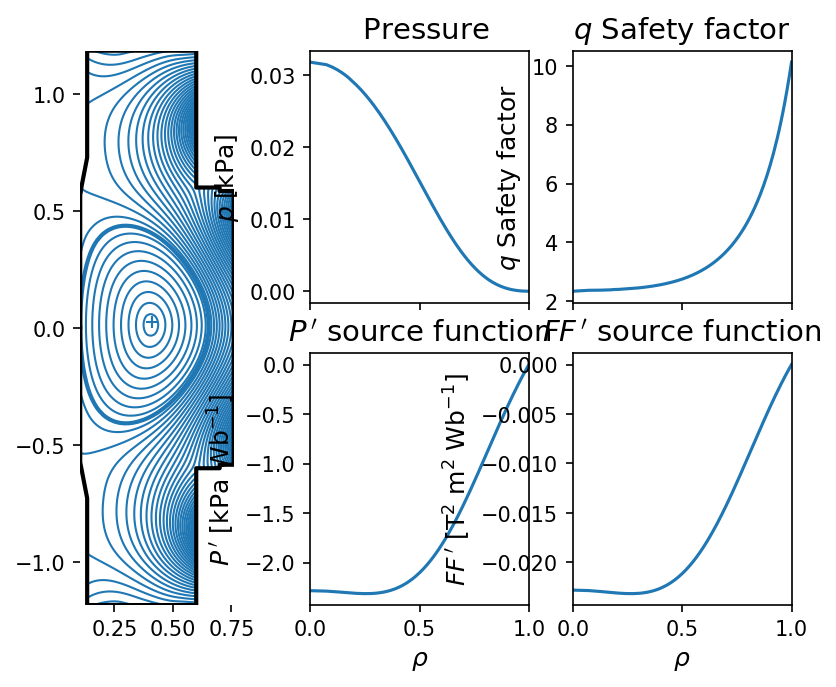

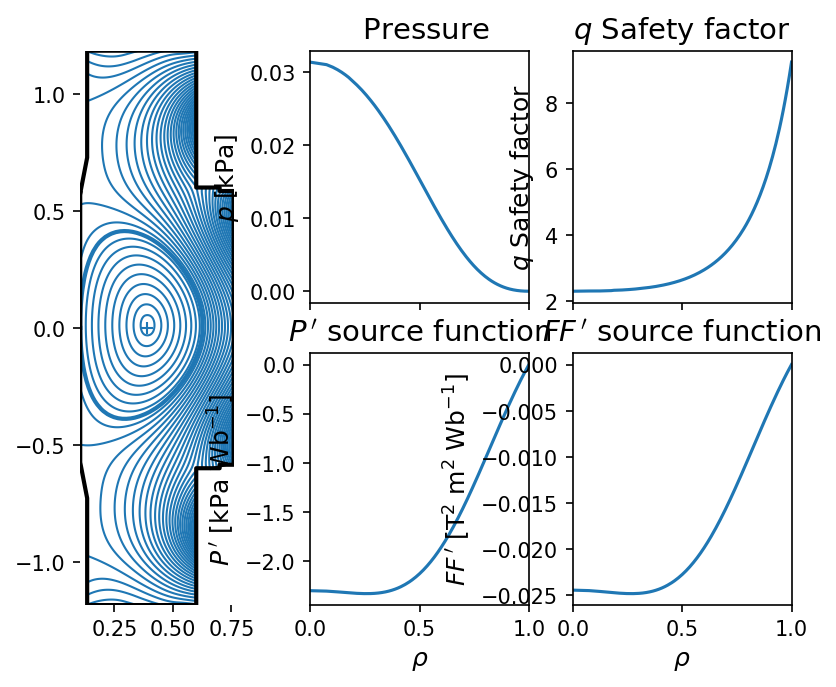

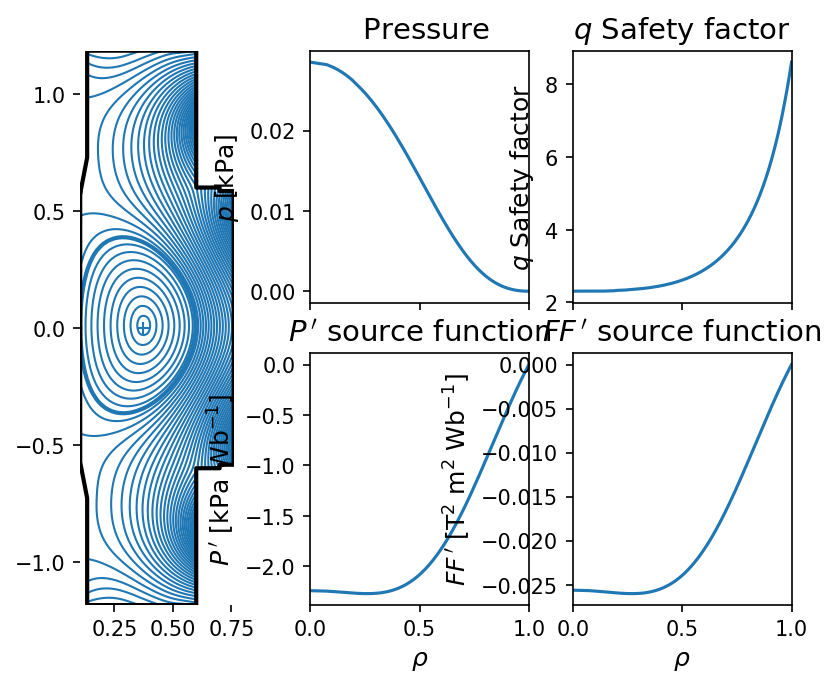

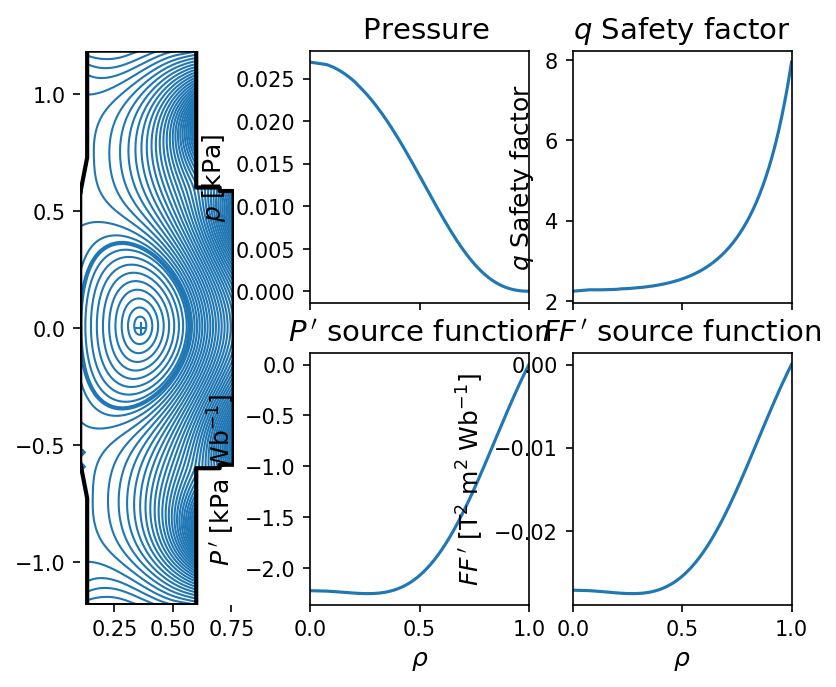

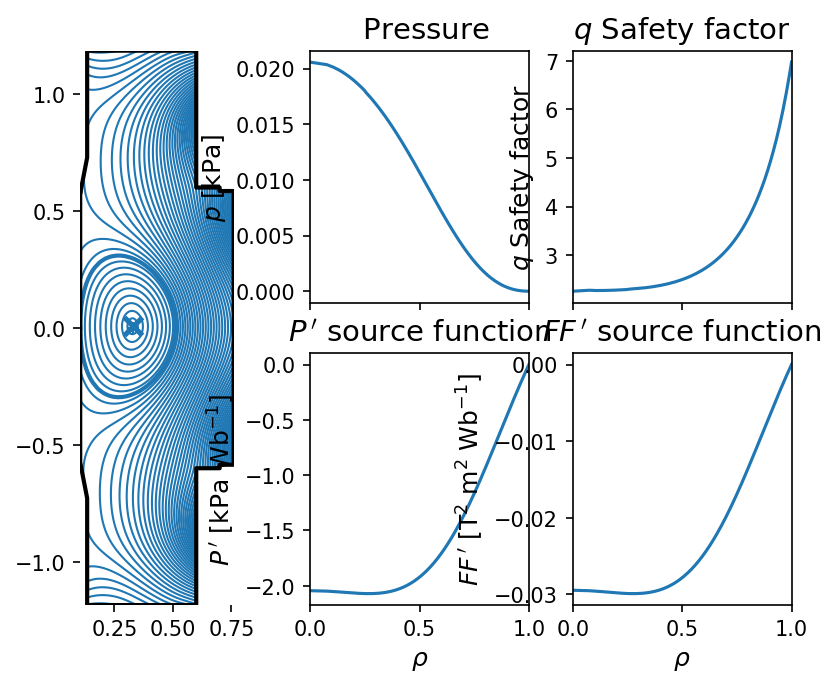

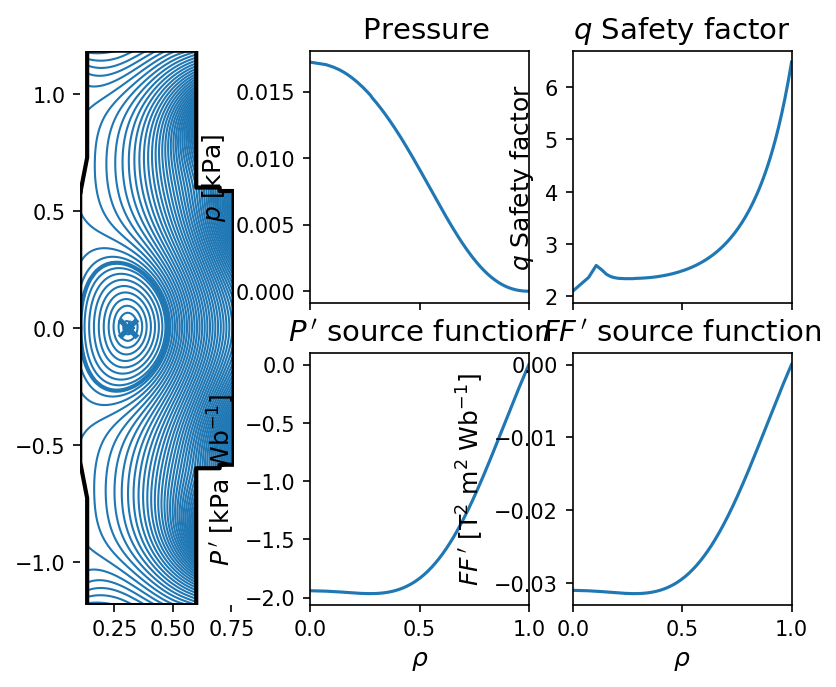

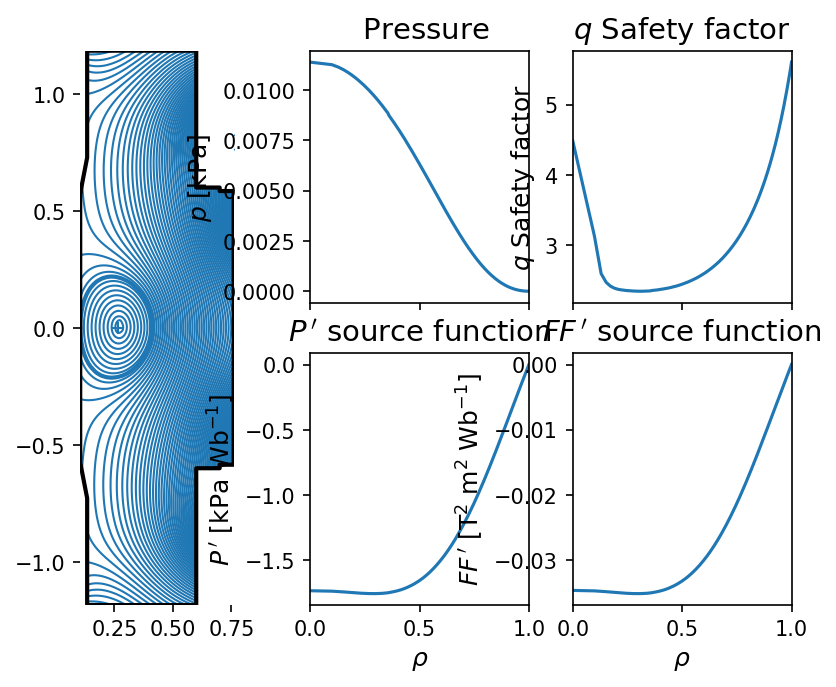

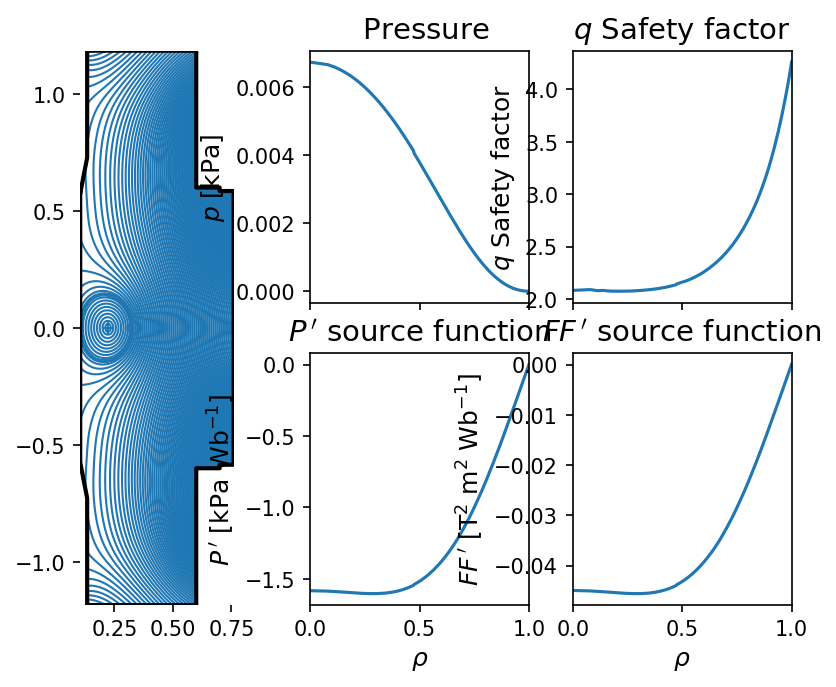

In [52]:
from omas import *
ods_json=load_omas_json('/srv/vest.filedb/public/39916/omas/39916_efit.json')
for i in range(len(ods_json['equilibrium.time_slice'])):
    if ods_json[f'equilibrium.time_slice.{i}.global_quantities'] !={}:
        ods_json.plot_equilibrium_summary(time_index=i)

[INFO] Using equilibrium time slice 0


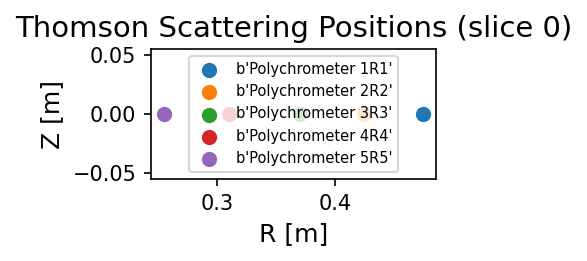

In [26]:
vaft.plot.plot_thomson_radial_position(ods)

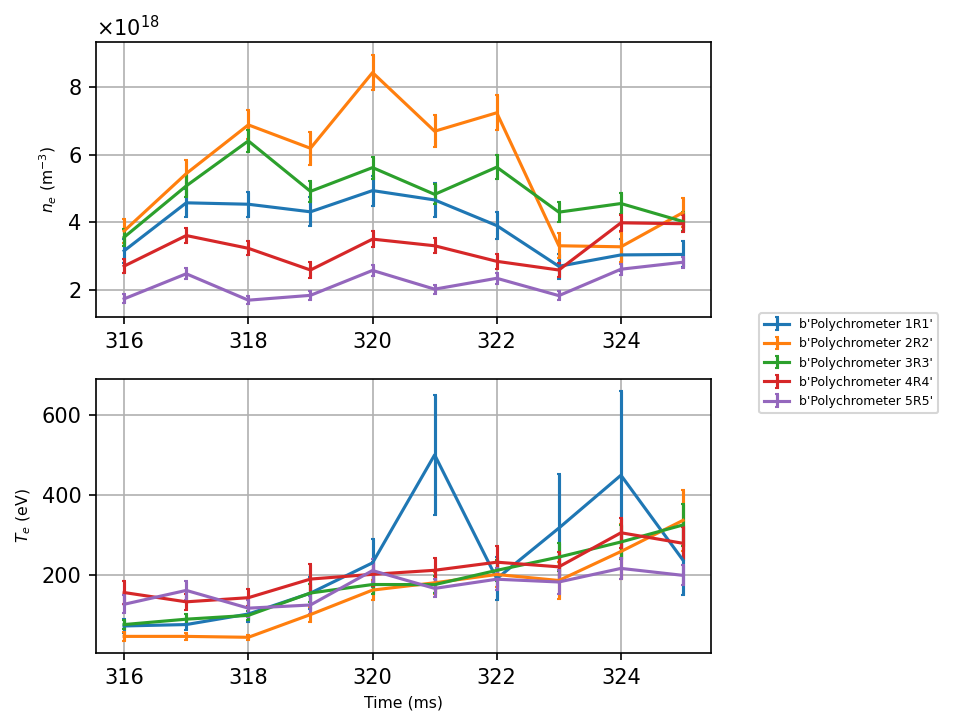

In [27]:
vaft.plot.plot_thomson_time_series(ods)

[INFO] Found 9 fitted core_profiles


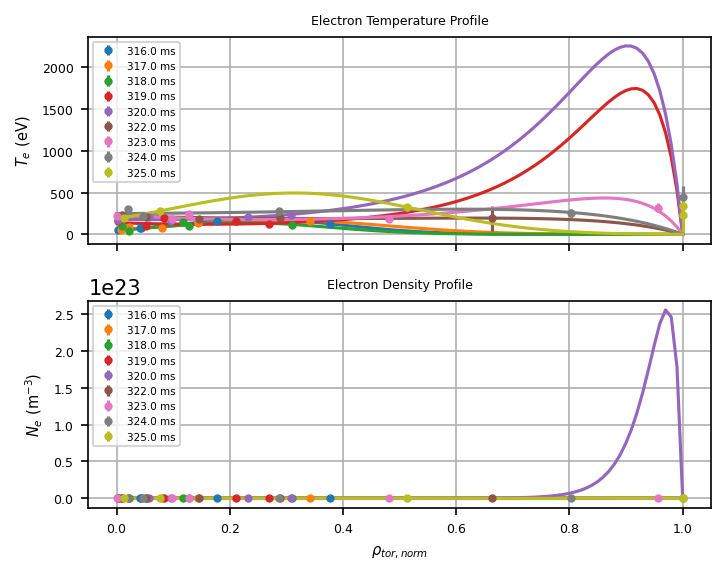

In [28]:
vaft.plot.plot_thomson_profiles(ods)